<a href="https://colab.research.google.com/github/sahanabikki/weather_classification/blob/main/Weather_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/new_kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d vijaygiitk/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset
License(s): CC0-1.0
 91% 123M/134M [00:00<00:00, 186MB/s] 
100% 134M/134M [00:01<00:00, 140MB/s]


In [ ]:
!unzip multiclass-weather-dataset.zip -d weather_data

Archive:  multiclass-weather-dataset.zip
  inflating: weather_data/dataset/alien_test/Cloud_1.png  
  inflating: weather_data/dataset/alien_test/Cloud_2.jpg  
  inflating: weather_data/dataset/alien_test/Cloud_3.jpeg  
  inflating: weather_data/dataset/alien_test/Cloud_4.jpg  
  inflating: weather_data/dataset/alien_test/foggy_1.jpg  
  inflating: weather_data/dataset/alien_test/foggy_10.jpg  
  inflating: weather_data/dataset/alien_test/foggy_2.jpg  
  inflating: weather_data/dataset/alien_test/foggy_3.jpg  
  inflating: weather_data/dataset/alien_test/foggy_4.jpg  
  inflating: weather_data/dataset/alien_test/foggy_5.jpg  
  inflating: weather_data/dataset/alien_test/foggy_6.jpg  
  inflating: weather_data/dataset/alien_test/foggy_7.jpg  
  inflating: weather_data/dataset/alien_test/foggy_8.jpg  
  inflating: weather_data/dataset/alien_test/foggy_9.jpg  
  inflating: weather_data/dataset/alien_test/rain_1.jpg  
  inflating: weather_data/dataset/alien_test/rain_2.png  
  inflating: we

In [ ]:
!ls weather_data

dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#2.configure image data generator
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
import os
import shutil
import random

# Set paths
dataset_path = r"/content/weather_data/dataset"
train_path = r"/content/weather_data/dataset/training"
test_path = r"/content/weather_data/dataset/alien_test"

# Ensure train and test directories exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Classes to include
classes = ["cloudy", "foggy", "rainy", "shine", "sunrise"]

# Split data
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    images = os.listdir(class_dir)

    # Shuffle images to ensure randomness
    random.shuffle(images)

    # Define number of images per class
    train_size = 300  # 1500 images / 5 classes = 300 per class
    test_size = 6     # 30 images / 5 classes = 6 per class

    # Ensure class directory exists before moving images
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # Move images to training set
    for img in images[:train_size]:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))

    # Move images to testing set
    for img in images[train_size:train_size + test_size]:
        shutil.move(os.path.join(class_dir, img), os.path.join(test_path, class_name, img))

print("Dataset split completed successfully!")

# Verify if images are correctly distributed
print(f"Training samples: {sum([len(files) for _, _, files in os.walk(train_path)])}")
print(f"Testing samples: {sum([len(files) for _, _, files in os.walk(test_path)])}")

# Apply ImageDataGenerator
train = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

test = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)


Dataset split completed successfully!
Training samples: 1493
Testing samples: 42
Found 1493 images belonging to 5 classes.
Found 12 images belonging to 5 classes.


In [ ]:
print(train.class_indices)

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}


In [ ]:
#import model building libraries
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
conv_base=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model=Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(units=256,activation="relu"))#hidden layers
model.add(Dense(units=5,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 21,138,757 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#let us freeze the conv_base because already trained
conv_base.trainable=False

In [ ]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics =['accuracy'])

In [ ]:
model.fit(train,steps_per_epoch=len(train),epochs=10,validation_data=test,validation_steps=len(test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 839s 9s/step - accuracy: 0.5817 - loss: 1.9945 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 853s 9s/step - accuracy: 0.8626 - loss: 0.3696 - val_accuracy: 0.7500 - val_loss: 0.3724
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 836s 9s/step - accuracy: 0.9203 - loss: 0.2357 - val_accuracy: 1.0000 - val_loss: 0.0558
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 872s 9s/step - accuracy: 0.9468 - loss: 0.1589 - val_accuracy: 1.0000 - val_loss: 0.0233
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 848s 9s/step - accuracy: 0.9668 - loss: 0.1046 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 862s 9s/step - accuracy: 0.9805 - loss: 0.0730 - val_accuracy: 1.0000 - val_loss: 0.0134
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 862s 9s/step - accuracy: 0.9794 - loss: 0.0818 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 860s 9s/step - accuracy: 0.9752 - loss: 0.0707 - val_accuracy: 0.9167 - v

In [ ]:
model.save("weather.h5")

In [ ]:
#checking model Accuracy
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics =['accuracy'])
loss, accuracy = model.evaluate(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 9.9373e-04


In [ ]:
#Testing the model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [ ]:
model=tf.keras.models.load_model(r"/content/weather.h5",compile=False)

In [ ]:
img=image.load_img(r"/content/weather_data/dataset/alien_test/rain_1.jpg",target_size=(224,224))

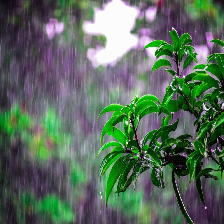

In [ ]:
img

In [ ]:
x=image.img_to_array(img)

In [ ]:
x

array([[[19., 18., 23.],
        [10.,  9., 14.],
        [ 9.,  8., 13.],
        ...,
        [17., 12., 19.],
        [28., 21., 29.],
        [18., 11., 19.]],

       [[19., 18., 23.],
        [12., 11., 16.],
        [ 9.,  8., 13.],
        ...,
        [25., 20., 26.],
        [24., 19., 25.],
        [19., 12., 19.]],

       [[22., 21., 26.],
        [17., 16., 21.],
        [15., 14., 19.],
        ...,
        [30., 28., 33.],
        [22., 17., 23.],
        [16.,  9., 16.]],

       ...,

       [[49., 59., 50.],
        [48., 58., 50.],
        [44., 54., 46.],
        ...,
        [54., 43., 57.],
        [37., 27., 38.],
        [36., 25., 41.]],

       [[46., 56., 45.],
        [47., 54., 46.],
        [45., 51., 47.],
        ...,
        [49., 38., 52.],
        [35., 25., 36.],
        [38., 27., 43.]],

       [[42., 52., 41.],
        [45., 52., 44.],
        [44., 49., 45.],
        ...,
        [51., 40., 54.],
        [39., 29., 40.],
        [38., 27., 43.]]

In [ ]:
x=np.expand_dims(x,axis=0)

In [ ]:
x.shape

(1, 224, 224, 3)

In [ ]:
pred=model.predict(x)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.9165993e-12,
        0.0000000e+00]], dtype=float32)

In [ ]:
pred.argmax()

2

In [ ]:
Index=['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [ ]:
result=Index[pred.argmax()]
result

'rainy'